In [1]:
import ROOT



Welcome to JupyROOT 6.30/02


In [2]:
def create_lorentz_vector(pt, eta, phi, m):
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiM(pt, eta, phi, m)
    return lv

def process_file(file_path, tree_name, blind_mass=False):
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)

    invariant_masses = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            lead_bjet_pt = event.lead_bjet_pt
            lead_bjet_eta = event.lead_bjet_eta
            lead_bjet_phi = event.lead_bjet_phi
            lead_bjet_mass = event.lead_bjet_mass
            sublead_bjet_pt = event.sublead_bjet_pt
            sublead_bjet_eta = event.sublead_bjet_eta
            sublead_bjet_phi = event.sublead_bjet_phi
            sublead_bjet_mass = event.sublead_bjet_mass

            # Default genweight to 1.0 if not available
            genweight = getattr(event, "genweight", 1.0)

            lv1 = create_lorentz_vector(lead_bjet_pt, lead_bjet_eta, lead_bjet_phi, lead_bjet_mass)
            lv2 = create_lorentz_vector(sublead_bjet_pt, sublead_bjet_eta, sublead_bjet_phi, sublead_bjet_mass)

            lv = lv1 + lv2
            invariant_mass = lv.M()

            # Apply blinding
            if blind_mass and 110 <= invariant_mass <= 140:
                continue

            invariant_masses.append((invariant_mass, genweight))

    file_1.Close()
    return invariant_masses


In [3]:
def process_signal_file(file_path, tree_name, blind_mass=False):
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)

    signal_masses = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            pt = event.HHbbggCandidate_pt
            eta = event.HHbbggCandidate_eta
            phi = event.HHbbggCandidate_phi
            mass = event.HHbbggCandidate_mass
            genweight = getattr(event, "genweight", 1.0)

            # Apply blinding
            if blind_mass and 110 <= mass <= 140:
                continue

            lv_signal = create_lorentz_vector(pt, eta, phi, mass)
            signal_masses.append((lv_signal.M(), genweight))

    file_1.Close()
    return signal_masses

In [4]:
data_file_paths = ["../../output_root/Data_EraE.root", "../../output_root/Data_EraF.root", "../../output_root/Data_EraG.root"]

background_files = [
    ("../../output_root/GGJets.root", "GGJets"),
    ("../../output_root/GJetPt20To40.root", "GJetPt20To40"),
    ("../../output_root/GJetPt40.root", "GJetPt40"),
    ("../../output_root/GluGluHToGG.root", "GluGluHToGG"),
    ("../../output_root/ttHToGG.root", "ttHToGG"),
    ("../../output_root/VBFHToGG.root", "VBFHToGG"),
    ("../../output_root/VHToGG.root", "VHToGG")
]

signal_file = "../../output_root/GluGluToHH.root"

cross_sections = {
    "GGJets": 88.75,
    "GJetPt20To40": 242.5,
    "GJetPt40": 919.1,
    "GluGluHToGG": 39.91,
    "ttHToGG": 0.0013,
    "VBFHToGG": 0.00926,
    "VHToGG": 0.00545,
    "GluGluToHH": 0.1186
}

tree_name = "DiphotonTree/data_125_13TeV_NOTAG"

integrated_luminosities = {
    "Data_EraE": 5.8070,
    "Data_EraF": 17.7819,
    "Data_EraG": 3.0828
}

In [5]:
blind_mass = True  # Set this to True to enable blinding

data_invariant_masses = []
signal_masses = []

for data_file_path in data_file_paths:
    data_sample_name = data_file_path.split("/")[-1].split(".")[0]
    luminosity = integrated_luminosities.get(data_sample_name, 1.0)
    data_invariant_masses.extend(process_file(data_file_path, tree_name, blind_mass))

    file = ROOT.TFile(data_file_path, "READ")
    tree = file.Get(tree_name)
    if tree:
        for event in tree:
            pt = event.HHbbggCandidate_pt
            eta = event.HHbbggCandidate_eta
            phi = event.HHbbggCandidate_phi
            mass = event.HHbbggCandidate_mass
            genweight = getattr(event, "genweight", 1.0)  # Default genweight to 1.0 if not available

            # Apply blinding
            if blind_mass and 110 <= mass <= 140:
                continue

            lv_signal = create_lorentz_vector(pt, eta, phi, mass)
            signal_masses.append((lv_signal.M(), genweight))
    file.Close()


In [6]:
# Signal and background processing
signal_masses = process_signal_file(signal_file, tree_name)

hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass, genweight in data_invariant_masses:
    hist_data.Fill(mass, genweight)

hist_signal = ROOT.TH1F("hist_signal", "Signal", 20, 80, 180)
total_luminosity = sum(integrated_luminosities.values())
n_events_signal = sum([w for _, w in signal_masses])
cross_section_signal = cross_sections["GluGluToHH"]
weight_signal = cross_section_signal * total_luminosity / n_events_signal

for mass, genweight in signal_masses:
    hist_signal.Fill(mass, genweight * weight_signal)

background_hists = {}

hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]


for idx, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    
    file = ROOT.TFile.Open(background_file)
    tree = file.Get(tree_name)
    n_events = sum([getattr(event, "genweight", 1.0) for event in tree])
    file.Close()
    
    cross_section = cross_sections.get(bg_name, 1.0)
    weight = cross_section * total_luminosity / n_events
    
    for mass, genweight in bg_invariant_masses:
        bg_hist.Fill(mass, genweight * weight)
    
    color_idx = idx % len(rgb_colors)
    color = ROOT.TColor.GetColor(*rgb_colors[color_idx])
    bg_hist.SetFillColor(color)
    background_hists[bg_name] = bg_hist

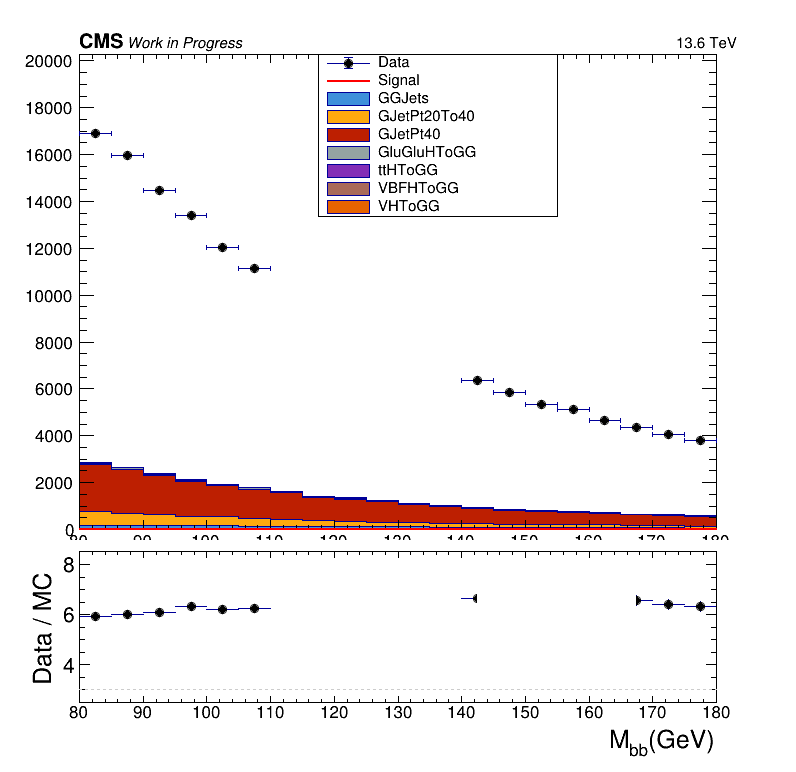

In [7]:
canvas = ROOT.TCanvas("canvas", "Invariant Mass", 800, 800)

pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

stack = ROOT.THStack("stack", "")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.2)
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")
hist_signal.SetLineColor(ROOT.kRed)
hist_signal.SetLineWidth(2)
hist_signal.Draw("SAME HIST")


stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.08)
stack.GetYaxis().SetTitleOffset(1.2)



legend = ROOT.TLegend(0.4, 0.6, 0.7, 0.9)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(hist_signal, "Signal", "l")
for bg_name, bg_hist in background_hists.items():
    legend.AddEntry(bg_hist, bg_name, "f")
legend.Draw()

cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.16, 0.91, "Work in Progress")

energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.85, 0.91, "13.6 TeV")

stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)



In [8]:
# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")
hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)
hist_ratio.SetStats(0)
hist_ratio.GetXaxis().SetTitle("M_{bb}(GeV)")  # Change X-axis label here
hist_ratio.GetXaxis().SetLabelSize(0.08)
hist_ratio.GetXaxis().SetTitleSize(0.12)
hist_ratio.GetXaxis().SetTitleOffset(0.9)

hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.25)
hist_ratio.SetMinimum(2.5)
hist_ratio.SetMaximum(8.5)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)

# Add grid lines on the X-axis manually
for x in range(80, 181, 10):
    line = ROOT.TLine(x, 0.5, x, 1.5)
    line.SetLineStyle(2)
    line.SetLineColor(ROOT.kGray)
    line.Draw()

line = ROOT.TLine(80, 1, 180, 1)
line.SetLineStyle(2)
line.SetLineColor(ROOT.kRed)
line.Draw()

line = ROOT.TLine(80, -1, 180, -1)
line.SetLineStyle(2)
line.SetLineColor(ROOT.kRed)
line.Draw()

line = ROOT.TLine(80, 2, 180, 2)
line.SetLineStyle(2)
line.SetLineColor(ROOT.kRed)
line.Draw()

line = ROOT.TLine(80, -2, 180, -2)
line.SetLineStyle(2)
line.SetLineColor(ROOT.kRed)
line.Draw()

line = ROOT.TLine(80, 3, 180, 3)
line.SetLineStyle(2)
line.SetLineColor(ROOT.kRed)
line.Draw()

line = ROOT.TLine(80, -3, 180, -3)
line.SetLineStyle(2)
line.SetLineColor(ROOT.kRed)
line.Draw()

hist_ratio.Draw("ep")





In [9]:
# Create legend for signal and background
legend2 = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
legend2.SetBorderSize(0)
legend2.AddEntry(hist_data, "Data", "lep")
legend2.AddEntry(hist_signal, "Signal (x50)", "l")
for bg_name, bg_hist in background_hists.items():
    legend2.AddEntry(bg_hist, bg_name, "f")
legend2.Draw()

# # Create another legend for Higgs processes
# legend3 = ROOT.TLegend(0.15, 0.6, 0.35, 0.8)
# legend3.SetBorderSize


# Draw grid lines on the y-axis manually
for y in range(-3, 4):
    line = ROOT.TLine(80, y, 180, y)
    line.SetLineStyle(2)
    line.SetLineColor(ROOT.kGray)
    line.Draw()

# Scale signal by 100 times
hist_signal.Scale(20)

# Remove legend from the ratio plot
legend2.Clear()

# Redraw the canvas
canvas.cd()
canvas.Update()

# Save canvas as PDF
canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding.pdf")
canvas.Draw()


Info in <TCanvas::Print>: pdf file /afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding.pdf has been created
